# Apprentissage de représentation, Texte et recommendation 

## Partie A : Prise en main TorchText et représentation

Vincent Guigue, à partir des supports de:

Nicolas Baskiotis (nicolas.baskiotis@sorbonne-univeriste.fr) Benjamin Piwowarski (benjamin.piwowarski@sorbonne-universite.fr) -- MLIA/ISIR, Sorbonne Université

<a href=https://pytorch.org/text/stable/index.html> **TorchText** </a> est le module de pytorch pour le pré-traitement du texte. Il permet entre autre les opérations usuelles de pré-traitement et de tokenization, et contient beaucoup d'autres outils adaptés au deep. Assurez vous d'avoir la dernière version d'installée (>=0.11.0).

In [14]:
import torchtext
import torch
assert torchtext.__version__ >= "0.11.0"
from torch.utils.tensorboard import SummaryWriter
import time
import matplotlib.pyplot as plt
TB_PATH = "/tmp/logs/module3"
%reload_ext tensorboard
%tensorboard --logdir  {TB_PATH}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Reusing TensorBoard on port 6010 (pid 48996), started 0:41:36 ago. (Use '!kill 48996' to kill it.)

cpu


# Représentation en espace continue

L'objectif de cette partie est  d'explorer et de comprendre la notion de représentation en espace continu (*embedding*). Il s'agit de *projeter* des objets pour la plupart du temps discrets (des mots, des index d'utilisateurs ou d'items) dans un espace continue d'une dimension de représentation choisie. Une bonne représentation permet entre autre d'exprimer une *sémantique* sur les objets projetés. Elle est souvent  construite à partir d'une notion de similarité qui doit être préservée en termes de distance dans l'espace projeté : les objets qui sont *proches* en un sens défini doivent également être proches dans l'espace de représentation. Ces *nouvelles* représentations peuvent ensuite être utilisée comme nouvelle description de l'objet d'étude dans une multitude de tâches (classification, clustering, traduction, ...).  Plus récemment, on utilise ce que l'on appelle un *apprentissage end-to-end*, c'est-à-dire que les représentations sont apprises en même temps que le réseau chargé d'une tâche en question. En effet, d'un point de vue réseau de neurones, un apprentissage de représentation n'est rien d'autre qu'une couche linéaire d'un espace de dimenion le nombre d'objet vers l'espace de représentation : un index est attribué à chaque objet arbitrairement et il est ensuite encodé en vecteur *one-hot* : un vecteur de la taille le nombre d'objet qui ne contient que des 0 sauf à l'index de l'objet qui vaut 1. Les poids du réseau linéaire sont ainsi les coordonnées vectorielles de chaque objet dans le nouvel espace de représentation. Pytorch a un module dédié : <a href=https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html> le **nn.Embedding**</a>.


**Remarque importante :** lorsque la dimension est grande, la distance euclidienne n'est pas significative. On préfère utiliser la similarité *cosine* : $cosine(\mathbf{x},\mathbf{z}) = \frac{\langle \mathbf{x},\mathbf{z}\rangle}{\|\mathbf{x}\|\|\mathbf{y}\|}$ qui dénote l'angle entre les deux vecteurs.



## Chargement et pré-processing des données.

Nous utiliserons l'exemple suivant : 

In [2]:
exemple = [
    'the cat is on the bank',
    'the bank near the black cat',
    'a big dog with a ball',
    'dog and cat are not similar',
    'dog and child with a ball',
    'white bird on a big tree']

Il faut bien sûr toujours pré-processer le texte. **Torchtext** contient différents moteurs de pré-processing (dont ceux de **spacy**, cf <a href=https://pytorch.org/text/stable/data_utils.html> la doc </a>). 

La classe de base qui permet de manipuler un corpus est la classe <a href=https://pytorch.org/text/stable/vocab.html> **Vocab**</a>. Elle permet de faire le lien entre un token et son index par l'intermédiaire d'un dictionnaire *string -> idx* et d'une liste qui permet de récuperer le token correspondant à un indice. Un objet <a href=https://pytorch.org/text/stable/vocab.html#vectors> Vectors</a> permet de faire le lien entre un indice et la représentation vectorielle du token correspondant.


In [3]:
## On récupère un tokenizer
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")
tokens = [tokenizer(doc) for doc in exemple]
## On construit le vocabulaire associé. 
## Il est possible de filtrer en fonction de la fréquence et d'ajouter des tokens spéciaux : 
## <pad> pour un caractère vide et <oov> pour un mot qui n'apparaît pas dans le vocabulaire.
vocab = torchtext.vocab.build_vocab_from_iterator(tokens,min_freq=1)

In [4]:
## On affiche toutes les représentations disponibles
print(torchtext.vocab.pretrained_aliases.keys())
## On prend une des  plus légères
fasttext = torchtext.vocab.FastText('simple')
## On construit notre propre vecteur qui correspond à notre vocabulaire.
vectors = []
for s in vocab.get_itos():
    vectors.append(fasttext.vectors[fasttext.stoi[s]])
vectors = torch.stack(vectors)
    

dict_keys(['charngram.100d', 'fasttext.en.300d', 'fasttext.simple.300d', 'glove.42B.300d', 'glove.840B.300d', 'glove.twitter.27B.25d', 'glove.twitter.27B.50d', 'glove.twitter.27B.100d', 'glove.twitter.27B.200d', 'glove.6B.50d', 'glove.6B.100d', 'glove.6B.200d', 'glove.6B.300d'])


.vector_cache/wiki.simple.vec: 293MB [00:14, 20.1MB/s]                              
100%|██████████| 111051/111051 [00:08<00:00, 13271.29it/s]


In [5]:
print("Mapping vocabulaire -> identifiant",list(fasttext.stoi.items())[:20],"\n")
print("Mapping identifiant -> vocabulaire",fasttext.itos[:20],"\n")
print("Vecteur de représentation des mots  the et bird", fasttext.get_vecs_by_tokens(["the","birds"])[:,:20])
print("Vecteur du mot bird : ", fasttext.vectors[fasttext.stoi["birds"]][:20])

Mapping vocabulaire -> identifiant [('</s>', 0), ('.', 1), (',', 2), ('the', 3), ('of', 4), ("'", 5), ('in', 6), ('-', 7), ('and', 8), (')', 9), ('(', 10), ('a', 11), ('to', 12), ('is', 13), ('was', 14), ('it', 15), ('for', 16), ('on', 17), ('s', 18), ('as', 19)] 

Mapping identifiant -> vocabulaire ['</s>', '.', ',', 'the', 'of', "'", 'in', '-', 'and', ')', '(', 'a', 'to', 'is', 'was', 'it', 'for', 'on', 's', 'as'] 

Vecteur de représentation des mots  the et bird tensor([[ 1.0399e-02, -1.8291e-01,  7.6084e-02, -1.8541e-01,  9.9364e-02,
          1.9839e-01, -1.6722e-01, -1.3452e-02, -2.8677e-04,  2.6706e-03,
          9.7921e-02, -1.1183e-01, -1.3611e-01,  1.3828e-01,  1.3663e-03,
          8.9178e-02,  6.2126e-02,  1.3424e-01,  1.9727e-02, -1.3894e-01],
        [ 7.1273e-01,  9.0417e-02,  2.3113e-01, -2.4010e-01,  3.4579e-01,
         -2.9609e-01,  1.3830e-01, -3.0154e-01, -1.8437e-01, -1.2250e-01,
         -4.9281e-01, -1.3723e-01, -4.2864e-03, -1.0009e-01, -4.8112e-01,
          2

## <span class="alert-success"> Exercice : manipulation des représentations </span>



**TensorBoard** possède un très bon visualiseur d'embeddings qui permet de choisir entre TSNE et ACP pour la méthode de réduction de dimensions. On peut bien sûr utiliser tout autre outil de visualisation.
Visualisez les embeddings. Notez la répartition des mots dans l'espace. 
Pour mieux appréhender la distance entre les mots, visualisez les similarités entre mots en traçant la heatmap des produits scalaires entre chaque couple de mots.

In [13]:
writer = SummaryWriter(f"{TB_PATH}/embexemples"+time.asctime())

writer.add_embedding(vectors,metadata=vocab.get_itos())

%reload_ext tensorboard


In [ ]:

## Visualisation de la matrice de similarité mat, avec la liste des labels correspondant
def viz_sim(mat,labels):
    fig, ax = plt.subplots(1,1)
    ax.imshow(mat)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    _=ax.set_xticklabels(labels,rotation=90),ax.set_yticklabels(labels)
    plt.show()


torch.Size([20, 300])


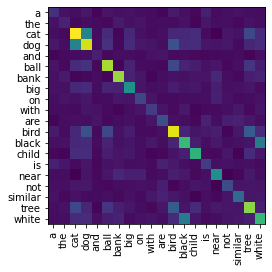

In [11]:
## Visualisation de la matrice de similarité (produit scalaire entre les représentations des mots)

print(vectors.shape)
viz_sim(vectors @ vectors.T, vocab.get_itos())

In [10]:
vocab.get_itos()

['a',
 'the',
 'cat',
 'dog',
 'and',
 'ball',
 'bank',
 'big',
 'on',
 'with',
 'are',
 'bird',
 'black',
 'child',
 'is',
 'near',
 'not',
 'similar',
 'tree',
 'white']

Une première représentation d'une phrase peut être réalisée en concatenant les représentations de tous ses tokens sur un même vecteur. Visualisez la heatmap des similarités entre phrases avec cette représentation. Quelle est le problème évident de ce genre de représentation ?

In [ ]:
## Concaténation des tokens des phrases et visualisation de la similarité


Une autre représentation consiste à faire la moyenne des représentations des tokens de la phrase. Visualisez la similarité en utilisant cette représentation. Améliore-t-elle les résultats ?

In [ ]:
## Construction de l'embedding moyen d'une phrase et visualisation des similarités
